In [4]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import validation_curve

# Task1:

## Load and subsample the dataset, choose 4000 rows from each data set 

In [47]:
filename = "OP_DTL_GNRL_PGYR2017_P01182019.csv"
n = sum(1 for line in open(filename)) - 1 
s = 4000 
skip = sorted(random.sample(range(1,n+1),n-s)) 
df_no = pd.read_csv('OP_DTL_GNRL_PGYR2017_P01182019.csv', skiprows=skip)
import warnings
warnings.filterwarnings('ignore')
filename = "OP_DTL_RSRCH_PGYR2017_P01182019.csv"
n = sum(1 for line in open(filename)) - 1 
s = 4000 
skip = sorted(random.sample(range(1,n+1),n-s)) 
df_res = pd.read_csv('OP_DTL_RSRCH_PGYR2017_P01182019.csv', skiprows=skip)

### this is from online

In [368]:
df_res['research']=1
df_no["research"]=0
df=df_no.append(df_res)

## Keep overlapping columns and remove columns with more than 70% missing

In [369]:
for each in list(df):
    if each not in list(df_res):
        df=df.drop(columns=each)
    if each not in list(df_no):
        df=df.drop(columns=each)

In [370]:
for each in list(df):
    if sum(df[each].isna())>=5600:
        df=df.drop(columns=each)

In [371]:
df['Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_ID'] = df['Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_ID'].astype(str)
df['Physician_Profile_ID'] = df['Physician_Profile_ID'].astype(str)
df['Record_ID'] = df['Record_ID'].astype(str)

### remove columns with single value

In [372]:

df=df.drop(columns=['Record_ID'])
df=df.drop(columns=['Program_Year'])

df=df.drop(columns=['Delay_in_Publication_Indicator','Dispute_Status_for_Publication','Payment_Publication_Date','Recipient_Country'])

df=df.drop(columns=['Recipient_Primary_Business_Street_Address_Line2'])

In [373]:
df=df.reset_index()
df=df.drop(columns=['index'])

In [374]:
for x in list(df) :
    df[x]=df[x].fillna('Missing')

## Our own target encoding method

In [170]:
def target_encode(df,column):
    df_test=pd.crosstab(df[column],df['research'])
    df_test['prob']=df_test.iloc[:,1]/(df_test.iloc[:,1]+df_test.iloc[:,0])
    
    for i in range (0,8000):
        x=df.loc[i,column]
        df.loc[i,column]=df_test.loc[x]['prob']
        
    df[column] = df[column].astype(float)
        
    return df

Here, we use "crosstab" to help us do target encoding. It produces the feature frequency regarding target variable. Then the function calculates the corresponding frequency of each categorical variable.

In [228]:
Cat=list(df)
Cat=Cat[:-2]

### target encode these categorical variables

In [132]:
df_target_encode=df
for cat in Cat:
    df_target_encode=target_encode(df_target_encode,cat)

### calculate covariance between each pair of features, and features having high covariance with target feature, is leakage. we want to remove these features and those features with very low covariance.

In [134]:
df_target_encode_cov=df_target_encode.cov()
df_test=df_target_encode_cov.sort_values(by=['research'],ascending=False)
df_test['research']

Total_Amount_of_Payment_USDollars                                   1640.210552
research                                                               0.250031
Physician_Profile_ID                                                   0.247808
Physician_Last_Name                                                    0.244360
Recipient_Primary_Business_Street_Address_Line1                        0.239059
Physician_First_Name                                                   0.236816
Physician_Specialty                                                    0.230361
Physician_License_State_code1                                          0.229327
Physician_Primary_Type                                                 0.228892
Covered_Recipient_Type                                                 0.228855
Recipient_Zip_Code                                                     0.189406
Name_of_Drug_or_Biological_or_Device_or_Medical_Supply_1               0.163438
Applicable_Manufacturer_or_Applicable_GP

###  leakage features:
Physician_Profile_ID  
Physician_Last_Name                                                   
Recipient_Primary_Business_Street_Address_Line1                        
Physician_First_Name                                                  
Physician_Specialty                                                   
Physician_License_State_code1                                          
Physician_Primary_Type                                                
Covered_Recipient_Type 

### irrelevant features:
Recipient_State, 
Change_Type, 
Related_Product_Indicator 

### the rest features are relevant

## drop above features

In [375]:
leakage=['Physician_Profile_ID','Physician_Last_Name',
         'Recipient_Primary_Business_Street_Address_Line1','Physician_First_Name',
         'Physician_Specialty','Physician_License_State_code1','Physician_Primary_Type','Covered_Recipient_Type']

In [376]:
df=df.drop(columns=leakage)

In [231]:
irrelevant=['Recipient_State','Change_Type','Related_Product_Indicator']

In [138]:
df_target_encode=df_target_encode.drop(columns=leakage)
df_target_encode=df_target_encode.drop(columns=irrelevant)

# Task 2:

In [377]:
from sklearn.linear_model import LogisticRegression

In [378]:
X_train, X_test, y_train, y_test = train_test_split(df.loc[:, df.columns != 'research'],df['research'],random_state=42)
categorical= X_train.dtypes==object

preprocess = make_column_transformer(
    (OneHotEncoder(handle_unknown='ignore'), categorical)
    #(StandardScaler(),~categorical)
)

linear = make_pipeline(preprocess, LogisticRegression())
valid_scores = cross_val_score(linear, X_train, y_train,cv=10)
print('LogisticRegression mean cv accuracy: {:.4f}'.format(np.mean(valid_scores)))

LogisticRegression mean cv accuracy: 0.9447


## Task 3:

### drop irrelevant features and add standarscaler

In [302]:
df=df.drop(columns=irrelevant)

In [303]:
df = df.sample(frac=1)
X_train, X_test, y_train, y_test = train_test_split(df.loc[:, df.columns != 'research'],df['research'],random_state=42)
categorical= X_train.dtypes==object

preprocess = make_column_transformer(
    (OneHotEncoder(handle_unknown='ignore'), categorical),
    (StandardScaler(),~categorical)
)

linear = make_pipeline(preprocess, LogisticRegression())
valid_scores = cross_val_score(linear, X_train, y_train,cv=10)
print('LogisticRegression mean cv accuracy: {:.4f}'.format(np.mean(valid_scores)))

LogisticRegression mean cv accuracy: 0.9508


### linear model with target encoding:

In [380]:
df = df.sample(frac=1)
X_train, X_test, y_train, y_test = train_test_split(df_target_encode.loc[:, df_target_encode.columns != 'research'],df_target_encode['research'],random_state=42)
categorical= X_train.dtypes==object

preprocess = make_column_transformer(
    (StandardScaler(),~categorical)
)

linear = make_pipeline(preprocess, LogisticRegression())
valid_scores = cross_val_score(linear, X_train, y_train,cv=10)
print('LogisticRegression mean accuracy R2: {:.4f}'.format(np.mean(valid_scores)))


LogisticRegression mean accuracy R2: 0.9845


Here target encoder imporves the accuracy of the logistic regression model. The target encoding method we build above is to calculate the frequency of each categorical feature regarding to target variable. We think it maybe better than One Hot Encoder. We will compare these two methods in the following model selection(specifically in Gradient Boosting model)

## Task 4:

### Linear SVM:

In [341]:

from sklearn.svm import LinearSVC
df = df.sample(frac=1)
X_train, X_test, y_train, y_test = train_test_split(df.loc[:, df.columns != 'research'],df['research'],random_state=42)
categorical= X_train.dtypes==object

preprocess = make_column_transformer(
    (OneHotEncoder(handle_unknown='ignore'), categorical),
    (StandardScaler(),~categorical)
)
model_svc = make_pipeline(preprocess, LinearSVC())
scores_svc = cross_val_score(model_svc, X_train, y_train, cv=5)
print("Linear SVC(with default parameter) mean of CV accuracy: {}".format(np.mean(scores_svc)))

Linear SVC(with default parameter) mean of CV accuracy: 0.9691633148124872


In [238]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import StratifiedKFold
skfold = StratifiedKFold(n_splits=5, shuffle=True)
param_svc= {'linearsvc__C': np.logspace(-3, 3, 13)}
grid_svc = GridSearchCV(model_svc, param_svc, cv=5)
grid_svc.fit(X_train, y_train)
print("The cross-validation strategy is regular cross validation.")
print("The best parameter for LinearSVC is: {}".format(grid_svc.best_params_))
print("The best score for LinearSVC is: {}".format(grid_svc.best_score_))

The cross-validation strategy is regular cross validation.
The best parameter for LinearSVC is: {'linearsvc__C': 0.31622776601683794}
The best score for LinearSVC is: 0.9545


### Decision Tree:

In [213]:
from sklearn.tree import DecisionTreeClassifier
model_tree = make_pipeline(preprocess, DecisionTreeClassifier(random_state=0))
scores_tree = cross_val_score(model_tree, X_train, y_train, cv=5)
print("Decision tree(with default parameter) mean of CV accuracy: {}".format(np.mean(scores_tree)))

Decision tree(with default parameter) mean of CV accuracy: 0.9391638550906402


In [214]:
param_tree = {'decisiontreeclassifier__max_depth': range(1, 7)}
grid_tree = GridSearchCV(model_tree, param_tree, cv=5)
grid_tree.fit(X_train, y_train)
print("The cross-validation strategy is regular cross validation.")
print("The best parameter for Decision tree is: {}".format(grid_tree.best_params_))
print("The best score for Decision tree is: {}".format(grid_tree.best_score_))

The cross-validation strategy is regular cross validation.
The best parameter for Decision tree is: {'decisiontreeclassifier__max_depth': 6}
The best score for Decision tree is: 0.897


### Random Forest:

In [215]:
from sklearn.ensemble import RandomForestClassifier
model_rf = make_pipeline(preprocess, RandomForestClassifier())
scores_rf = cross_val_score(model_rf, X_train, y_train, cv=5)
print("Random Forest(with default parameter) mean of CV accuracy: {}".format(np.mean(scores_rf)))

Random Forest(with default parameter) mean of CV accuracy: 0.9373307983778693


In [216]:
param_rf = {'randomforestclassifier__max_features': range(1, 64,5),'randomforestclassifier__max_depth':range(1,10)}
grid_rf = GridSearchCV(model_rf, param_rf, cv=skfold)
grid_rf.fit(X_train, y_train)
print("The cross-validation strategy is stratified K-Fold method.")
print("The best parameter for Random Forest is: {}".format(grid_rf.best_params_))
print("The best score for Random Forest is: {}".format(grid_rf.best_score_))

The cross-validation strategy is stratified K-Fold method.
The best parameter for Random Forest is: {'randomforestclassifier__max_depth': 7, 'randomforestclassifier__max_features': 61}
The best score for Random Forest is: 0.8515


### GradientBoosting Classifier(with One Hot Encoder):   

In [239]:
from sklearn.ensemble import GradientBoostingClassifier
model_gb = make_pipeline(preprocess, GradientBoostingClassifier())
scores_gb = cross_val_score(model_gb, X_train, y_train, cv=5)
print("Gradient Boosting(with default parameter) mean of CV accuracy: {}".format(np.mean(scores_gb)))

Gradient Boosting(with default parameter) mean of CV accuracy: 0.9428333333333334


In [240]:
param_gb = {'gradientboostingclassifier__max_features': range(1, 64,5),'gradientboostingclassifier__max_depth':range(1,10)}
grid_gb = GridSearchCV(model_gb, param_gb, cv=skfold)
grid_gb.fit(X_train, y_train)
print("The cross-validation strategy is stratified K-Fold method.")
print("The best parameter for Gradien Boosting is: {}".format(grid_gb.best_params_))
print("The best score for Gradient Boosting is: {}".format(grid_gb.best_score_))

The cross-validation strategy is stratified K-Fold method.
The best parameter for Gradien Boosting is: {'gradientboostingclassifier__max_depth': 9, 'gradientboostingclassifier__max_features': 61}
The best score for Gradient Boosting is: 0.9468333333333333


### GradientBoosting Classifier(with Target Encoding): 

In [242]:
best_model=GradientBoostingClassifier(max_depth=grid_gb.best_params_['gradientboostingclassifier__max_depth'],
                                      max_features=grid_gb.best_params_['gradientboostingclassifier__max_features'])
best = make_pipeline(preprocess, best_model)
best.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('columntransformer', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('onehotencoder', OneHotEncoder(categorical_features=None, categories=None,
       dtype=<class 'numpy.float64'>, handle_unknown='ignore',
   ...    subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False))])

In [334]:
X_train, X_test, y_train, y_test = train_test_split(df_target_encode.loc[:, df_target_encode.columns != 'research'],df_target_encode['research'],random_state=42)


In [335]:
from sklearn.ensemble import GradientBoostingClassifier
model_gb = make_pipeline(preprocess, GradientBoostingClassifier())
scores_gb = cross_val_score(model_gb, X_train, y_train, cv=5)
print("Gradient Boosting(with default parameter) mean of CV accuracy: {}".format(np.mean(scores_gb)))

Gradient Boosting(with default parameter) mean of CV accuracy: 0.9901656887724689


In [338]:
param_gb = {'gradientboostingclassifier__max_depth':range(1,10)}
grid_gb = GridSearchCV(model_gb, param_gb, cv=skfold)
grid_gb.fit(X_train, y_train)
print("The cross-validation strategy is stratified K-Fold method.")
print("The best parameter for Gradien Boosting is: {}".format(grid_gb.best_params_))
print("The best score for Gradient Boosting is: {}".format(grid_gb.best_score_))

The cross-validation strategy is stratified K-Fold method.
The best parameter for Gradien Boosting is: {'gradientboostingclassifier__max_depth': 9}
The best score for Gradient Boosting is: 0.9928333333333333


## Task 5：

In [313]:
best=GradientBoostingClassifier(max_depth=9)

best.fit(X_train, y_train)


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=9,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [314]:
list(df_target_encode)[:-1]

['Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Country',
 'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_ID',
 'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name',
 'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_State',
 'Associated_Drug_or_Biological_NDC_1',
 'Covered_or_Noncovered_Indicator_1',
 'Date_of_Payment',
 'Form_of_Payment_or_Transfer_of_Value',
 'Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_1',
 'Name_of_Drug_or_Biological_or_Device_or_Medical_Supply_1',
 'Product_Category_or_Therapeutic_Area_1',
 'Recipient_City',
 'Recipient_Zip_Code',
 'Submitting_Applicable_Manufacturer_or_Applicable_GPO_Name',
 'Total_Amount_of_Payment_USDollars']

### below is feature importance

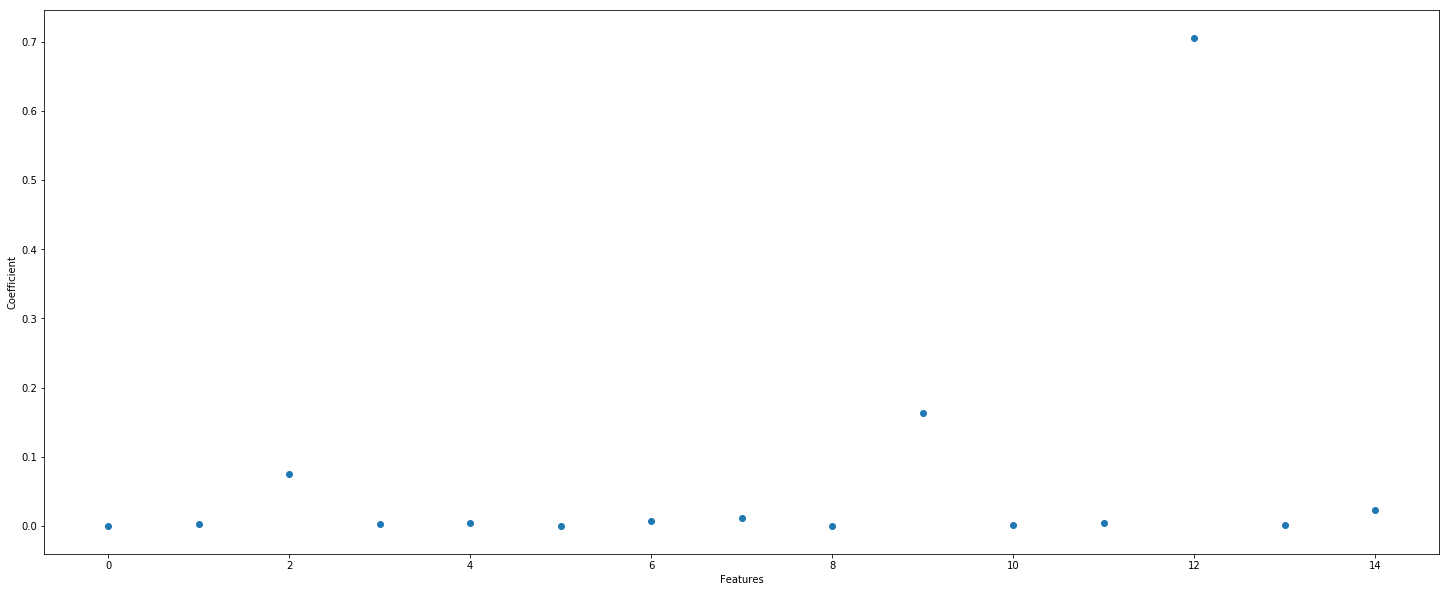

In [315]:
coef=best.feature_importances_
feature=list(df_target_encode)[:-1]
fig, axes = plt.subplots(figsize=(8, 12))
plt.scatter(range(len(coef)),coef.reshape(-1,1))
plt.xlabel("Features")
plt.ylabel("Coefficient")
fig.set_size_inches(25, 10)

Text(0.5,1,'Feature Importantce for Gradient Boosting')

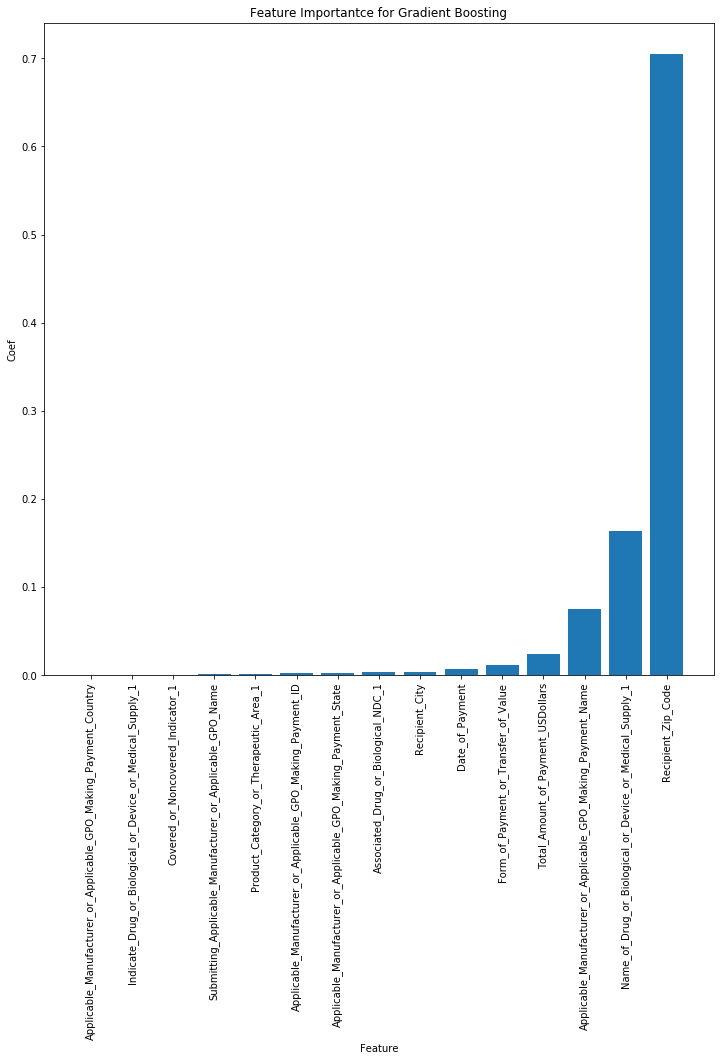

In [321]:
top_10_idx = np.argsort(coef)
top_10_features= [feature3[i] for i in top_10_idx]
top_10_coef=[coef[i] for i in top_10_idx]
fig, axes = plt.subplots(figsize=(12, 12))
plt.bar(top_10_features, top_10_coef, align='center')
plt.xlabel('Feature')
plt.xticks(rotation=90)
plt.ylabel('Coef')
plt.title('Feature Importantce for Gradient Boosting')

### feature to be removed:

In [329]:
irrelevant=top_10_features[:3]
df_test=df_target_encode
df_test=df_test.drop(columns=irrelevant)
print(irrelevant)

['Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Country', 'Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_1', 'Covered_or_Noncovered_Indicator_1']


In [332]:
X_train, X_test, y_train, y_test = train_test_split(df_target_encode.loc[:, df_target_encode.columns != 'research'],df_target_encode['research'],random_state=42)

best=GradientBoostingClassifier(max_depth=9)
scores_gb = cross_val_score(best, X_train, y_train, cv=5)
print("Gradient Boosting(with best parameter but without feature selection) mean of CV accuracy: {}".format(np.mean(scores_gb)))

Gradient Boosting(with best parameter but without feature selection) mean of CV accuracy: 0.9893317989572677


In [333]:
X_train, X_test, y_train, y_test = train_test_split(df_test.loc[:, df_test.columns != 'research'],df_test['research'],random_state=42)

best=GradientBoostingClassifier(max_depth=9)
scores_gb = cross_val_score(best, X_train, y_train, cv=5)
print("Gradient Boosting(with best parameter and without irrelevant features) mean of CV accuracy: {}".format(np.mean(scores_gb)))


Gradient Boosting(with default parameter and without irrelevant features) mean of CV accuracy: 0.9886651318276378


'Total_Amount_of_Payment_USDollars', 'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name', 'Name_of_Drug_or_Biological_or_Device_or_Medical_Supply_1', 'Recipient_Zip_Code' are top 4 most influential features. When we remove the three features with least importance, which are 'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Country', 'Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_1', 'Covered_or_Noncovered_Indicator_1', the result seems similar and even has a worse performance.

## Task 6:

In [360]:
important=top_10_features[-4:]
important.append('research')

In [361]:
df_simple=df_target_encode

In [362]:
df_simple=df_simple[important]

In [382]:
X_train, X_test, y_train, y_test = train_test_split(df_simple.loc[:, df_simple.columns != 'research'],df_simple['research'],random_state=42)

model_tree = DecisionTreeClassifier(random_state=0)
scores_tree = cross_val_score(model_tree, X_train, y_train, cv=5)
print("Decision tree(with default parameter) mean of CV accuracy: {}".format(np.mean(scores_tree)))



Decision tree(with default parameter) mean of CV accuracy: 0.9809988787029251


### This is the decision tree model with top 4 imporant features. The accuracy score is also very good.


Below are features we use in explainable model:
'Total_Amount_of_Payment_USDollars', 
'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name',
'Name_of_Drug_or_Biological_or_Device_or_Medical_Supply_1',
'Recipient_Zip_Code'

'Total_Amount_of_Payment_USDollars': a reasearch project is highly likely to be costly, so if this variavle is very high, then the payment is more likely to be made to a research project.

'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name': this variable represents name of pharmaceutical company. Some pharmaceutical companies might tend to support research, thus make many patments to support research project.

'Name_of_Drug_or_Biological_or_Device_or_Medical_Supply_1': some drug or devices are more likely to be used in research project. Thus payment about these drug or devices tends to be made to research project.

'Recipient_Zip_Code': some organizations might do a lot research projects, and their addresses are fixed.